<a href="https://colab.research.google.com/github/KSY1526/myblog/blob/master/_notebooks/2022-01-27-FirstDeep4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "[처음 시작하는 딥러닝] 4. 밑바닥부터 만들어보는 RNN"
- author: Seong Yeon Kim 
- categories: [book, jupyter, Deep Learning, matrix, math, class]

# 자동미분

In [41]:
import numpy as np

a = np.array([2,3,1,0])

print(a)
print('__add__ 함수 사용:', a.__add__(4))
print('+ 연산자 사용:', a + 4)

[2 3 1 0]
__add__ 함수 사용: [6 7 5 4]
+ 연산자 사용: [6 7 5 4]


파이썬에서는 + 연산자를 사용할 때 내부에서  _ _ add_ _  함수가 호출되는 방식입니다.

다른 연산자도 마찬가지로 연결된 함수를 불러오는 방식으로 실행됩니다.

In [42]:
from typing import Union, List

Numberable = Union[float, int] 
# 정수, 소수 둘다 함께하는 자료형 생성, 파이토치에서는 tensor가 비슷한 역할을 함.

def ensure_number(num: Numberable): # -> NumberWithGrad, 자료형으로 출력해줌.
    if isinstance(num, NumberWithGrad): # 자료형 확인함수
        return num
    
    else:
        return NumberWithGrad(num)

class NumberWithGrad(object):
    def __init__(self, num: Numberable,
                 depends_on : List[Numberable] = None,
                 creation_op: str = ''):
        self.num = num # 원래 값(숫자) 자체를 저장.
        self.grad = None
        self.depends_on = depends_on or []
        self.creation_op = creation_op

    def __add__(self, other: Numberable = None): # NumberWithGrad 출력
        return NumberWithGrad(self.num + ensure_number(other).num,
                              # 입력된 값 NumberWithGrad 자료형으로 변환 후 더하기.
                              depends_on = [self, ensure_number(other)],
                              # 3 + 4이면 [3, 4]로 저장(NumberWithGrad 자료형으로)
                              creation_op = 'add')
    
    def __mul__(self, other: Numberable = None): # NumberWithGrad 출력
        return NumberWithGrad(self.num * ensure_number(other).num,
                              depends_on = [self, ensure_number(other)],
                              creation_op = 'mul')
        
    def backward(self, backward_grad: Numberable = None) -> None:
        if backward_grad is None: # 이 함수가 처음 호출될때
            self.grad = 1

        # 이부분에서 기울기가 누적.
        else:
            if self.grad is None: # 기울기 정보가 아직 없다면
                self.grad = backward_grad # backward_grad로 설정

            else:
                self.grad += backward_grad # 있다면 기존 기울기에 backward_grad를 더함.


        # self.grad를 역방향으로 전달.
        # 둘 중 어느 요소를 증가시켜도 출력이 같은 값만큼 증가함.
        if self.creation_op == 'add':
            self.depends_on[0].backward(self.grad)
            self.depends_on[1].backward(self.grad)


        if self.creation_op == 'mul':
            # 첫번째 요소에 대한 미분 계산
            new = self.depends_on[1] * self.grad
            # 미분을 역방향으로 전달
            self.depends_on[0].backward(new.num)

            # 두번째 요소에 대한 미분 계산
            new = self.depends_on[0] * self.grad
            #미분을 역방향으로 전달.
            self.depends_on[1].backward(new.num)

a = NumberWithGrad(3)

b = a * 4
c = b + 5

c.backward()

print(a.grad)

4


자동 미분을 간단하게 구현한 함수입니다. 저도 이해하는데 꽤 걸렸는데 단기간에 이해하기 쉽진 않습니다.

우선 Numberable 자료형을 생성합니다. int, float 자료형을 통합했다고 보면 될 것 같아요. 또 ensure_number 함수는 입력되는 모든 값을 뒤에 나오는 NumberWithGrad 자료형으로 변환해준다고 생각하면 됩니다.

NumberWithGrad 클레스도 간단하게 하나의 자료형으로 이해하시는게 좋습니다. a = NumberWithGrad(3)은 3이라는 값을 NumberWithGrad 자료형으로 선언했다고 생각하면 됩니다.

이후 a * 4 코드가 진행되면 파이썬에서는 a. __ mul __(4) 함수를 써서 곱하기를 진행하는데, NumberWithGrad 자료형 내부에 __ mul __ 함수가 오버라이딩 되어있습니다.

오버라이딩 된 NumberWithGrad 내부 함수는 값 부분에 정상적인 곱하기 연산을 수행하고, depends_on 부분에 연산에 사용된 숫자를 NumberWithGrad 자료형으로 기록, creation_op 부분에 곱하기 연산이 수행됬다는 것을 기록합니다.

즉 b = a * 4 연산을 통해 b는 NumberWithGrad 자료형으로 바뀌고 연산에 사용된 숫자와 연산기호가 NumberWithGrad 자료형 내부에 저장됩니다.

c = b + 5 부분에서 c도 마찬가지로 NumberWithGrad 자료형으로 저장되며 b와 5가 depends_on 부분에 저장되는데 b 같은 경우 이전 NumberWithGrad 자료형 그대로 저장되는 것을 주목합시다.

그리고 c.backward() 함수를 실행하면 backward_grad 입력값에 아무것도 안 넣었기 때문에 첫번째 if문에 걸립니다. c의 grad 값은 1로 선언됩니다.

그 뒤 c를 만들기 위해 사용했던 연산기호가 + 이기 때문에 세번째 if문에 걸리게 되고 c를 만들어준 두 연산자가 기록되어 있는 depends_on을 이용해 다시 backward 함수를 실행시킵니다.

backward 함수를 실행시킬때 함수 입력값에 c.grad을 넣고 함수를 실행합니다. 상세히 말하면 c.depends_on[0] = b이기 때문에 b.backward(c.grad)를 실행합니다.

함수 입력값에 c.grad가 있기 때문에 두번째 if문에 걸리게 되고 b.grad 값에 1을 넣게 됩니다. 그 후 아까 c에서 벌어졌던 연산을 다시 반복합니다.

이후 내용을 한번 더 상세하게 설명하면 b를 만들기 위해 사용했던 연산기호가 * 이므로 네번째 if문에 걸리게 되고 여기서는 b.grad에 서로 반대되는 값을 곱해준 것을 backward 함수에 전달합니다.

과정이 조금 복잡해서 저도 되집어본다고 생각하고 클레스 구조를 간단히 서술했는데 관심있는 분들은 스스로 코드를 해석해보시면서 제 설명을 참고하시면 보다 쉽게 익힐 수 있을거 같아요. 이해 안되는 부분은 댓글달아주시면 아는 선에서 설명드리겠습니다.

In [43]:
a = NumberWithGrad(3)

b = a * 4
c = b + 3
d = (a + 2) # a 다시 사용.
e = c * d
e.backward()

print(a.grad)

35


아까보다 한단계 복잡한 자동미분 예시입니다. 실제 도함수를 통해 계산한 결과와 일치하는 것을 볼 수 있어요.

예제는 d = (4*a + 3) * (a + 2) 입니다.

자동 미분이 필요한 이유가 순방향 계산 과정의 중간 결과를 재사용 할 수 있습니다. 윗 예제도 a를 두번 써도 정상적으로 실행됩니다.

이전에 했던 합성함수 미분법을 활용했을때는 윗 예제와 같은 식을 설명할 수 없기 때문에 자동 미분 방법이 중요합니다.

# 필요한 라이브러리 임포트, 활성화 함수 선언

In [44]:
import numpy as np
from numpy import ndarray

from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
%matplotlib inline

from copy import deepcopy
from collections import deque

from scipy.special import logsumexp



def assert_same_shape(output, output_grad):
    assert output.shape == output_grad.shape, \
    '''
    두 ndarray의 모양이 같아야 하는데,
    첫 번째 ndarray의 모양은 {0}이고
    두 번째 ndarray의 모양은 {1}이다.
    '''.format(tuple(output_grad.shape), tuple(output.shape))
    return None

def assert_dim(t, dim):
    assert len(t.shape) == dim, \
    '''
    이 텐서는 {0}차원이어야 하는데, {1}차원이다.
    '''.format(dim, len(t.shape))
    return None


    

def sigmoid(x: ndarray):
    return 1 / (1 + np.exp(-x))


def dsigmoid(x: ndarray):
    return sigmoid(x) * (1 - sigmoid(x))


def tanh(x: ndarray):
    return np.tanh(x)


def dtanh(x: ndarray):
    return 1 - np.tanh(x) * np.tanh(x)


def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


def batch_softmax(input_array: ndarray):
    out = []
    for row in input_array:
        out.append(softmax(row, axis=1))
    return np.stack(out)

필요한 라이브러리와 활성화 함수를 선언했습니다.

# 옵티마이저, 손실함수

In [45]:
class RNNOptimizer(object):
    def __init__(self, lr: float = 0.01,
                 gradient_clipping: bool = True) -> None:
        self.lr = lr
        self.gradient_clipping = gradient_clipping
        self.first = True

    def step(self) -> None:

        for layer in self.model.layers:
            for key in layer.params.keys():

                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])

                self._update_rule(param=layer.params[key]['value'],
                                  grad=layer.params[key]['deriv'])

    def _update_rule(self, **kwargs) -> None:
        raise NotImplementedError()

RNNOptimizer 클레스를 통해 RNN에서 사용할 수 있는 옵티마이저의 기본 골격을 만들었습니다.

코드 내 상세 내용은 저도 정확히 모르겠습니다.

In [46]:
class SGD(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                 gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)

    def _update_rule(self, **kwargs) -> None:

        update = self.lr*kwargs['grad']
        kwargs['param'] -= update


class AdaGrad(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)
        self.eps = 1e-7

    def step(self) -> None:
        if self.first:
            self.sum_squares = {}
            for i, layer in enumerate(self.model.layers):
                self.sum_squares[i] = {}
                for key in layer.params.keys():
                    self.sum_squares[i][key] = np.zeros_like(layer.params[key]['value'])
            
            self.first = False

        for i, layer in enumerate(self.model.layers):
            for key in layer.params.keys():
                
                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])
                
                self._update_rule(param=layer.params[key]['value'],
                                  grad=layer.params[key]['deriv'],
                                  sum_square=self.sum_squares[i][key])

    def _update_rule(self, **kwargs) -> None:

            # 이전 기울기의 제곱의 합을 계산
            kwargs['sum_square'] += (self.eps +
                                     np.power(kwargs['grad'], 2))

            # 이전 5개 기울기의 제곱의 합으로 학습률을 수정
            lr = np.divide(self.lr, np.sqrt(kwargs['sum_square']))

            # 수정된 학습률을 적용
            kwargs['param'] -= lr * kwargs['grad']

앞서 만든 RNNOptimizer를 상속받아 SGD와 AdaGrad 옵티마이저 클레스를 만들었습니다.

In [47]:
class Loss(object):

    def __init__(self):
        pass

    def forward(self,
                prediction: ndarray,
                target: ndarray) -> float:

        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        self.output = self._output()

        return self.output
    
    def backward(self) -> ndarray:

        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        raise NotImplementedError()

        
class SoftmaxCrossEntropy(Loss):
    def __init__(self, eps: float=1e-9) -> None:
        super().__init__()
        self.eps = eps
        self.single_class = False

    def _output(self) -> float:

        out = []
        for row in self.prediction:
            out.append(softmax(row, axis=1))
        softmax_preds = np.stack(out)

        # 안정적인 계산을 위해 소프트맥스의 출력을 제한
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

        # 손실을 실제로 계산
        softmax_cross_entropy_loss = -1.0 * self.target * np.log(self.softmax_preds) - \
            (1.0 - self.target) * np.log(1 - self.softmax_preds)

        return np.sum(softmax_cross_entropy_loss)

    def _input_grad(self) -> np.ndarray:

        return self.softmax_preds - self.target

이 부분도 가벼운 마음으로 정리했습니다. 주가 아닌 부분이기 때문에 자세한 설명은 생략할께요.

# 순환 신경망 구현

In [48]:
class RNNLayer(object):

    def __init__(self, hidden_size, output_size, weight_scale = None):

        self.hidden_size = hidden_size # 은닉 뉴런수
        self.output_size = output_size 
        self.weight_scale = weight_scale
        self.start_H = np.zeros((1, hidden_size)) # 이 층에 내부상태 저장
        self.first = True # 처음임을 선언


    def _init_params(self, input_: ndarray): # input_ = x_seq_in
        
        self.vocab_size = input_.shape[2] # 사용되는 글자의 가짓수
        
        if not self.weight_scale:
            self.weight_scale = 2 / (self.vocab_size + self.output_size)
        
        # 밑에 나오는 것은 파라미터를 저장하기 위한 형식입니다.
        # 키 value부분은 실제 파라미터, 키 deriv는 그에대한 기울깃값입니다.
        self.params = {}
        self.params['W_f'] = {}
        self.params['B_f'] = {}
        self.params['W_v'] = {}
        self.params['B_v'] = {}
        
        self.params['W_f']['value'] = np.random.normal(loc = 0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size + self.vocab_size, self.hidden_size))
        self.params['B_f']['value'] = np.random.normal(loc = 0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.hidden_size))
        self.params['W_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(self.hidden_size, self.output_size))
        self.params['B_v']['value'] = np.random.normal(loc=0.0,
                                                      scale=self.weight_scale,
                                                      size=(1, self.output_size))    
        
        self.params['W_f']['deriv'] = np.zeros_like(self.params['W_f']['value'])
        self.params['B_f']['deriv'] = np.zeros_like(self.params['B_f']['value'])
        self.params['W_v']['deriv'] = np.zeros_like(self.params['W_v']['value'])
        self.params['B_v']['deriv'] = np.zeros_like(self.params['B_v']['value'])
        
        self.cells = [RNNNode() for x in range(input_.shape[1])] # input_shape[1] : 시간순서
        # 시간 순서만큼 RNN 노드를 리스트형태로 만들어 cells에 저장.

    
    def _clear_gradients(self):
        for key in self.params.keys():
            self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])

    
    def forward(self, x_seq_in: ndarray): # 입력값은 배치, 순서(시간), 변수 크기

        if self.first: # 처음이면
            self._init_params(x_seq_in) # 윗 함수 실행할 것.
            self.first = False # 처음 아닌 상태 표시

        batch_size = x_seq_in.shape[0] # 배치 크기 입력

        H_in = np.copy(self.start_H) # 은닉층 내부 상태 저장. (1, 은닉층)
        H_in = np.repeat(H_in, batch_size, axis = 0) # 은닉층 배치크기만큼 확대. (배치크기, 은닉층)

        sequence_length = x_seq_in.shape[1] # 순서형 자료 개수 입력

        x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))

        for t in range(sequence_length): # 순서형 자료 개수만큼
            x_in = x_seq_in[:, t, :] # 특정 시점에 입력값들.

            # RNN 노드 내 forward함수 실행. H_in 값이 지속적으로 업데이트 됩니다.
            y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
            x_seq_out[:, t, :] = y_out # 출력층에 값을 넣어줍니다.

        self.start_H = H_in.mean(axis = 0, keepdims = True) 
        # 마지막 은닉층 값을 기억합니다.

        return x_seq_out


    def backward(self, x_seq_out_grad: ndarray):
        
        batch_size = x_seq_out_grad.shape[0]

        h_in_grad = np.zeros((batch_size, self.hidden_size))

        sequence_length = x_seq_out_grad.shape[1]
        
        x_seq_in_grad = np.zeros((batch_size, sequence_length, self.vocab_size))


        for t in reversed(range(sequence_length)):
            x_out_grad = x_seq_out_grad[:, t, :]

            grad_out, h_in_grad = self.cells[t].backward(x_out_grad, h_in_grad, self.params)

            x_seq_in_grad[:, t, :] = grad_out

        return x_seq_in_grad

RNN 층을 직접 구현했습니다. 내용이 상당히 방대해 이해하기 쉽진 않습니다.

쉽게 정리하면 입력되는 형태는 (배치크기, 순서, 특성 크기) 인 3차원 입니다. 

그 후 층 내부에서는 처음에 배치단위별로 한 순서씩 모든 특성크기가 입력 됩니다.

층 내부 구조는 입력층, 히든층, 출력층으로 되어있으며 입력층은 입력된 특성크기 + 히든층 크기 로 구성되어있습니다.

히든층은 사용자가 정의하며, 출력층은 원하는 결과물에 따라 개수를 정해주면 됩니다.

이때 히든층은 지속적으로 업데이트되어 출력됩니다. 더 자세한 설명은 RNN 노드 부분에서 하겠습니다.

In [49]:
class RNNNode(object):
    def __init__(self):
        pass

    def forward(self, x_in: ndarray, H_in: ndarray,
                params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
                # params_dic 예시로 [B_f][value, ndarray] 로 생각하면 됩니다.
        
        self.X_in = x_in # (배치크기, 변수 크기)
        self.H_in = H_in # (배치크기, 은닉층 크기)

        self.Z = np.column_stack((x_in, H_in))
        # column_stack 함수는 두 넘파이 배열을 입력받아 열을 기준(여기선 배치마다)으로 병합합니다.
        # 즉 Z는 (배치크기, 변수 + 은닉층 크기) 입니다. 
        # 이 말은 입력값은 입력된 변수 + 이전 은닉층 값이라는 거죠. 이 부분이 핵심입니다.

        self.H_int = np.dot(self.Z, params_dict['W_f']['value'] + params_dict['B_f']['value'])
        # W_f는 (은닉층 + 변수, 은닉층), B_f는 (1, 은닉층), 두 개 합 또한 넘파이 재활용 규칙으로 (은닉층 + 변수, 은닉층).
        # 출력값은 (배치, 은닉층) 이 됩니다.
        self.H_out = tanh(self.H_int) # 은닉층 값에 활성화 함수를 거칩니다.

        self.X_out = np.dot(self.H_out, params_dict['W_v']['value'] + params_dict['B_v']['value'])
        # W_v는 (은닉층, 출력층), B_f는 (1, 출력층) 합은 재활용 규칙으로 (은닉층, 출력층)
        # 출력값은 (배치, 출력층)이 됩니다.

        return self.X_out, self.H_out # 출력층 값, 은닉층 값 돌려줍니다.


    def backward(self, X_out_grad: ndarray, H_out_grad: ndarray,
                 params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:

        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)
        
        params_dict['B_v']['deriv'] += X_out_grad.sum(axis = 0)
        params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)

        dh = np.dot(X_out_grad, params_dict['W_v']['value'].T)
        dh += H_out_grad

        dH_int = dh * dtanh(self.H_int)

        params_dict['B_f']['deriv'] += dH_int.sum(axis = 0)
        params_dict['W_f']['deriv'] += np.dot(self.Z.T, dH_int)

        dz = np.dot(dH_int, params_dict['W_f']['value'].T)

        X_in_grad = dz[:, :self.X_in.shape[1]]
        H_in_grad = dz[:, self.X_in.shape[1]:]

        assert_same_shape(X_out_grad, self.X_out)
        assert_same_shape(H_out_grad, self.H_out)

        return X_in_grad, H_in_grad

우선 역전파는 수리적으로 다소 어렵고 모델 구조 이해와 큰 연관이 없기 때문에 순전파 위주로 학습하겠습니다.

여기서 주목할 건 학습할 때 입력값만 쓰는 것이 아니라 이전 은닉층 값도 사용한다는 것입니다.

이전 은닉층 값은 이전 입력값과 연관이 있기 때문에 순서가 있는 데이터에서 상당히 유용합니다.

나머지 부분은 코드 내 주석을 잘 읽어보시고, 이해가 안되시면 댓글 써주시면 아는 선에서 답변 드리겠습니다.

In [50]:
class RNNModel(object):

    def __init__(self, layers: List[RNNLayer], 
                 sequence_length, vocab_size, loss: Loss):
        
        self.layers = layers # 층을 리스트 단위로 입력
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.loss = loss

        for layer in self.layers:
            # 층마다 sequence_length 값 지정
            setattr(layer, 'sequence_length', sequence_length)


    def forward(self, x_batch: ndarray):

        for layer in self.layers:
            # x_batch : (배치, 순서값, 특성값)
            x_batch = layer.forward(x_batch)

        return x_batch

    def backward(self, loss_grad: ndarray):

        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad)

        return loss_grad

    def single_step(self, x_batch, y_batch):

        # 순방향 계산
        x_batch_out = self.forward(x_batch)
        
        # 손실 및 손실의 기울기 계산
        loss = self.loss.forward(x_batch_out, y_batch)
        loss_grad = self.loss.backward()

        for layer in self.layers:
            layer._clear_gradients()

        # 역방향 계산
        self.backward(loss_grad)
        return loss

이 클래스는 입력과 목푯값으로 신경망을 실제로 학습해 손실을 계산합니다.

층들을 리스트로 입력받으며 single_step 함수를 사용해 실제 연산을 진행합니다.

# 자연어 관련 실습

In [51]:
class RNNTrainer:

    def __init__(self, text_file: str, model: RNNModel,
                 optim: RNNOptimizer, batch_size = 32):
        
        self.data = open(text_file, 'r').read()
        self.model = model
        self.chars = list(set(self.data))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch:i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i:ch for i, ch in enumerate(self.chars)}
        self.sequence_length = self.model.sequence_length
        self.batch_size = batch_size
        self.optim = optim
        setattr(self.optim, 'model', self.model)

    def _generate_inputs_targets(self, start_pos):
        
        inputs_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        targets_indices = np.zeros((self.batch_size, self.sequence_length), dtype=int)
        
        for i in range(self.batch_size):
            
            inputs_indices[i, :] = np.array([self.char_to_idx[ch] 
                            for ch in self.data[start_pos + i: start_pos + self.sequence_length  + i]])
            targets_indices[i, :] = np.array([self.char_to_idx[ch] 
                         for ch in self.data[start_pos + 1 + i: start_pos + self.sequence_length + 1 + i]])

        return inputs_indices, targets_indices


    def _generate_one_hot_array(self, indices: ndarray):
        '''
        param indices: 모양이 (batch_size, sequence_length)인 넘파이 배열
        return batch - 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
        ''' 
        batch = []
        for seq in indices:
            
            one_hot_sequence = np.zeros((self.sequence_length, self.vocab_size))
            
            for i in range(self.sequence_length):
                one_hot_sequence[i, seq[i]] = 1.0

            batch.append(one_hot_sequence) 

        return np.stack(batch)


    def sample_output(self, input_char, sample_length):
        '''
        현재 학습된 모델로 한 글자씩 출력을 생성한다.
        param input_char: int - 연속열을 시작하는 글자의 인덱스에 해당하는 정수
        param sample_length: int - 생성할 연속열의 길이
        return txt: string - 길이가 sample_length이며 모델을 통해 생성한 문자열
        '''
        indices = []
        
        sample_model = deepcopy(self.model)
        
        for i in range(sample_length):
            input_char_batch = np.zeros((1, 1, self.vocab_size))
            
            input_char_batch[0, 0, input_char] = 1.0
            
            x_batch_out = sample_model.forward(input_char_batch)
            
            x_softmax = batch_softmax(x_batch_out)
            
            input_char = np.random.choice(range(self.vocab_size), p=x_softmax.ravel())
            
            indices.append(input_char)
            
        txt = ''.join(self.idx_to_char[idx] for idx in indices)
        return txt

    def train(self, num_iterations, sample_every = 100):
        '''
        "글자 생성기"를 학습
        각 반복마다 신경망에 크기가 1인 배치가 입력된다
        num_iterations회 반복한다. 매 반복마다 현재 학습된 모델로 생성한 텍스트가 출력된다.
        '''
        plot_iter = np.zeros((0))
        plot_loss = np.zeros((0))
        
        num_iter = 0
        start_pos = 0
        
        moving_average = deque(maxlen=100)
        while num_iter < num_iterations:
            
            if start_pos + self.sequence_length + self.batch_size + 1 > len(self.data):
                start_pos = 0
            
            ## 모델 수정
            inputs_indices, targets_indices = self._generate_inputs_targets(start_pos)

            inputs_batch, targets_batch = \
                self._generate_one_hot_array(inputs_indices), self._generate_one_hot_array(targets_indices)
            
            loss = self.model.single_step(inputs_batch, targets_batch)
            self.optim.step()
            
            moving_average.append(loss)
            ma_loss = np.mean(moving_average)
            
            start_pos += self.batch_size
            
            plot_iter = np.append(plot_iter, [num_iter])
            plot_loss = np.append(plot_loss, [ma_loss])
            
            if num_iter % 100 == 0:
                plt.plot(plot_iter, plot_loss)
                display.clear_output(wait=True)
                plt.show()
                
                sample_text = self.sample_output(self.char_to_idx[self.data[start_pos]], 
                                                 200)
                print(sample_text)

            num_iter += 1

텍스트 파일과 모델을 전달받아 이어지는 글자를 예측하는 트레이너 입니다.

자연어 관련 실습을 하기 위해 가져온 트레이너이기 때문에 자세한 설명은 생략하겠습니다.

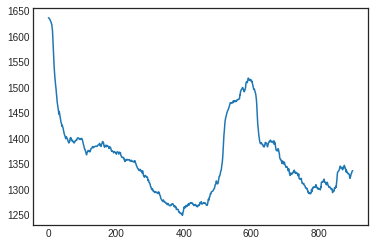

haglaw ahd Fh wo:'ZiNJyFB yPsiEIiw :O woreyVVklEer y chimulmwofeoyTid?Phee
IQSFZUinl;QhJvkP ikQw;KtUe
;khoahort fhaonZgb!ugor.;;wlZA oa;eyDbiT
 NlhbmoeLe Pneeh'by,ne ajburPtUs zY xar ary
jIsuor.wZwTDH


In [52]:
layers = [RNNLayer(hidden_size=256, output_size=62)]
mod = RNNModel(layers=layers,
               vocab_size=62, sequence_length=10,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.001, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim)
trainer.train(1000, sample_every=100)

간단한 실습을 해봤습니다. 사실 자세한 내용은 잘 이해가 안되는데 직접 구현한 코드로도 실제 실습이 된다는 점을 중요하게 생각하겠습니다.

# 느낀점

코드는 엄청 길지 않은데 진짜 이해하는데 한참걸렸던 것 같습니다.

RNN, 순환 신경망. 재사용한다는 것 까진 알겠는데 뭐가 어떻게 재사용이 되서 시계열, 자연어 처리에 쓰이는데? 하는 의문을 가졌는데요.

100% 해결했다라고 자신있기 말하진 못하겠지만 어느정도 느낌은 받았던 것 같습니다. RNN 구조에 대해 직관적으로 머리 속에 들어온 것 같아요.

특히 RNN 층 관련 내용 학습할 때, 긴 시간 씨름하다 이해가 됬을때 정말 기뻤습니다. 또 자동미분부분도 재밌게 했던 것 같아요.